#Predictive analysis, target feature: Event_type

**Load libraries**

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/eeg data/totall_df.csv'

In [4]:
df = pd.read_csv(path)
df.tail()

,Example_names,F1_th/al,F1_th/beta,F1_th/gama,F2_th/al,F2_th/beta,F2_th/gama,T1_th/al,T1_th/beta,T1_th/gama,...,O1_th/gama,O2_th/al,O2_th/beta,O2_th/gama,Example,Day_time_h,Event_type,SFN_treat,Num_per_h,Dur_per_h
3322,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.376390,0.808605,14.442618,0.354407,0.646204,12.138190,0.413740,0.983833,23.487378,...,13.437017,0.360715,0.590758,7.511864,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3323,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.444862,0.883468,14.071816,0.413103,0.788776,13.421757,0.410607,0.911440,20.187075,...,14.771327,0.456566,0.861803,11.286298,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3324,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.471139,0.874434,11.718948,0.449249,0.813695,11.918224,0.431847,0.903160,16.261716,...,13.442645,0.508233,0.921530,9.931513,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3325,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.377731,0.824558,13.373822,0.348138,0.699460,12.694106,0.371347,0.898335,16.742484,...,13.953187,0.369664,0.693528,9.799755,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0
3326,SFN4_200612-201201_152114-EegAnt01_SFN4_200612...,0.534603,1.093385,19.617927,0.472650,0.777563,13.089325,0.474034,1.066304,24.289437,...,20.030298,0.517533,0.879643,13.251053,SFN4,12-16,SEIZURE,No_SFN,7.912088,12.0


In [5]:
df.shape

(3327, 31)

In [48]:
# Fianl column manupulations
df_transformed = df.drop(columns = ['Example_names', 'Example', 'Dur_per_h', 'Num_per_h'])
df_transformed['Event_type'] = df_transformed['Event_type'].replace ('Seizure', 'SEIZURE')

df_transformed = df_transformed[[col for col in df_transformed.columns if col !='Event_type'] + ['Event_type']]

print (df_transformed.columns)
df_transformed['Event_type'].nunique()

Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama', 'Day_time_h',
       'SFN_treat', 'Event_type'],
      dtype='object')


3

In [8]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327 entries, 0 to 3326
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   F1_th/al    3327 non-null   float64
 1   F1_th/beta  3327 non-null   float64
 2   F1_th/gama  3327 non-null   float64
 3   F2_th/al    3327 non-null   float64
 4   F2_th/beta  3327 non-null   float64
 5   F2_th/gama  3327 non-null   float64
 6   T1_th/al    3327 non-null   float64
 7   T1_th/beta  3327 non-null   float64
 8   T1_th/gama  3327 non-null   float64
 9   T2_th/al    3327 non-null   float64
 10  T2_th/beta  3327 non-null   float64
 11  T2_th/gama  3327 non-null   float64
 12  P1_th/al    3327 non-null   float64
 13  P1_th/beta  3327 non-null   float64
 14  P1_th/gama  3327 non-null   float64
 15  P2_th/al    3327 non-null   float64
 16  P2_th/beta  3327 non-null   float64
 17  P2_th/gama  3327 non-null   float64
 18  O1_th/al    3327 non-null   float64
 19  O1_th/beta  3327 non-null  

In [132]:
# Defining target column
X= df_transformed.drop(columns = ['Event_type'])
y = df_transformed['Event_type']

In [133]:
# Define the feature groups: numerical and categorical
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
print ('Numerical features:')
print (numerical_features)
print ('Categorical features:')
print (categorical_features)

Numerical features:
Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_th/al', 'O1_th/beta',
       'O1_th/gama', 'O2_th/al', 'O2_th/beta', 'O2_th/gama'],
      dtype='object')
Categorical features:
Index(['Day_time_h', 'SFN_treat'], dtype='object')


**Checking data for multicollinearity**

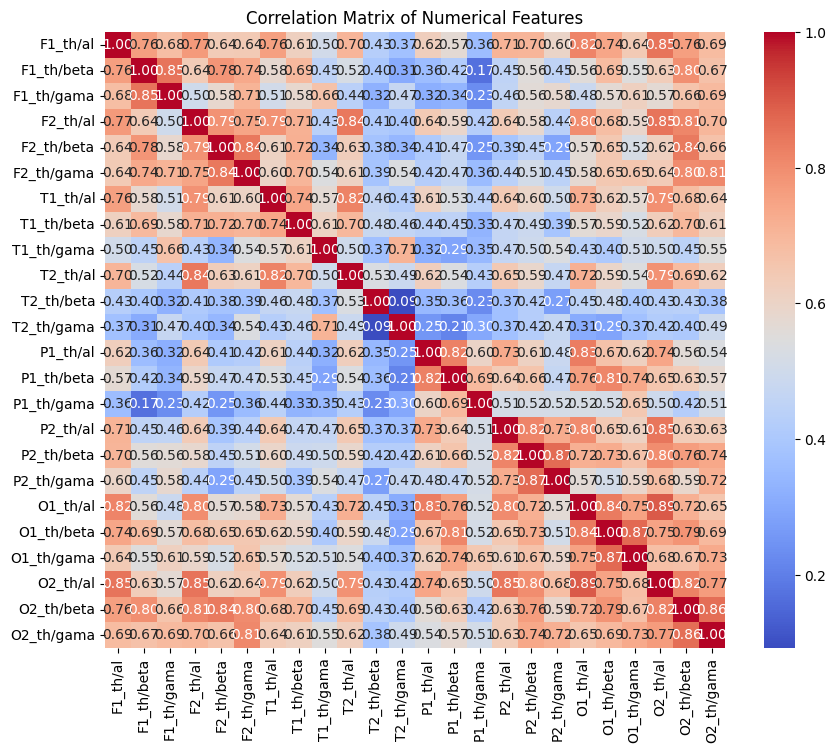

In [134]:
correlation_matrix = df_transformed[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [135]:
# Choose labels with correlation > 0.85
high_corr_pairs = np.where(correlation_matrix > 0.9)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j]
high_corr_pairs

[]

The result shows absence of high multicollinearity in the dataset

In [136]:
# Setting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2661, 26), (666, 26), (2661,), (666,))

In [137]:
# Transforming target feature to binary format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [138]:
# Check the mapping in encoded y_train (event_type):
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Class mapping: {'IED': 0, 'MS': 1, 'SEIZURE': 2}


In [139]:
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Масштабування числових ознак
])

# Створення Pipeline для категоріальних ознак
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))  # One-hot кодування категоріальних ознак
])


In [140]:
# Creating Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),

    ('classifier', xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=4, eta=0.1, n_estimators=100))
])

In [141]:
# Model training
model.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['F1_th/al', 'F1_th/beta', 'F1_th/gama', 'F2_th/al', 'F2_th/beta',
       'F2_th/gama', 'T1_th/al', 'T1_th/beta', 'T1_th/gama', 'T2_th/al',
       'T2_th/beta', 'T2_th/gama', 'P1_th/al', 'P1_th/beta', 'P1_th/gama',
       'P2_th/al', 'P2_th/beta', 'P2_th/gama', 'O1_...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=3, ...))])

**Model cross-validation**

In [142]:
cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores)}')
print(f'Standard deviation: {np.std(cv_scores)}')

Cross-validation scores: [0.73358349 0.71428571 0.72180451 0.69360902 0.70488722]
Mean accuracy: 0.7136339911692928
Standard deviation: 0.013730768665844391


In [143]:
# Estimation by different metrics of accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='macro')
recall = recall_score(y_test_encoded, y_pred, average='macro')
f1 = f1_score(y_test_encoded, y_pred, average='macro')
report = classification_report(y_test_encoded, y_pred)

# Виведення результатів
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)

Accuracy: 0.6966966966966966
Precision: 0.6156375494310465
Recall: 0.5792999704566357
F1 Score: 0.578224747062824
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       194
           1       0.42      0.18      0.25       126
           2       0.73      0.92      0.81       346

    accuracy                           0.70       666
   macro avg       0.62      0.58      0.58       666
weighted avg       0.66      0.70      0.67       666



In [144]:
with open('classification_report_modell_events.txt', 'w') as file:
    file.write(report)

**Visualization Precision-Recall curve**

In [145]:
# Probabilities foe train and test data
y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_test)

In [146]:
# OneHotCoding for target label : train and test
encoder = OneHotEncoder(sparse_output=False)

y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

In [147]:
# Class number
n_classes = y_train_encoded.shape[1]

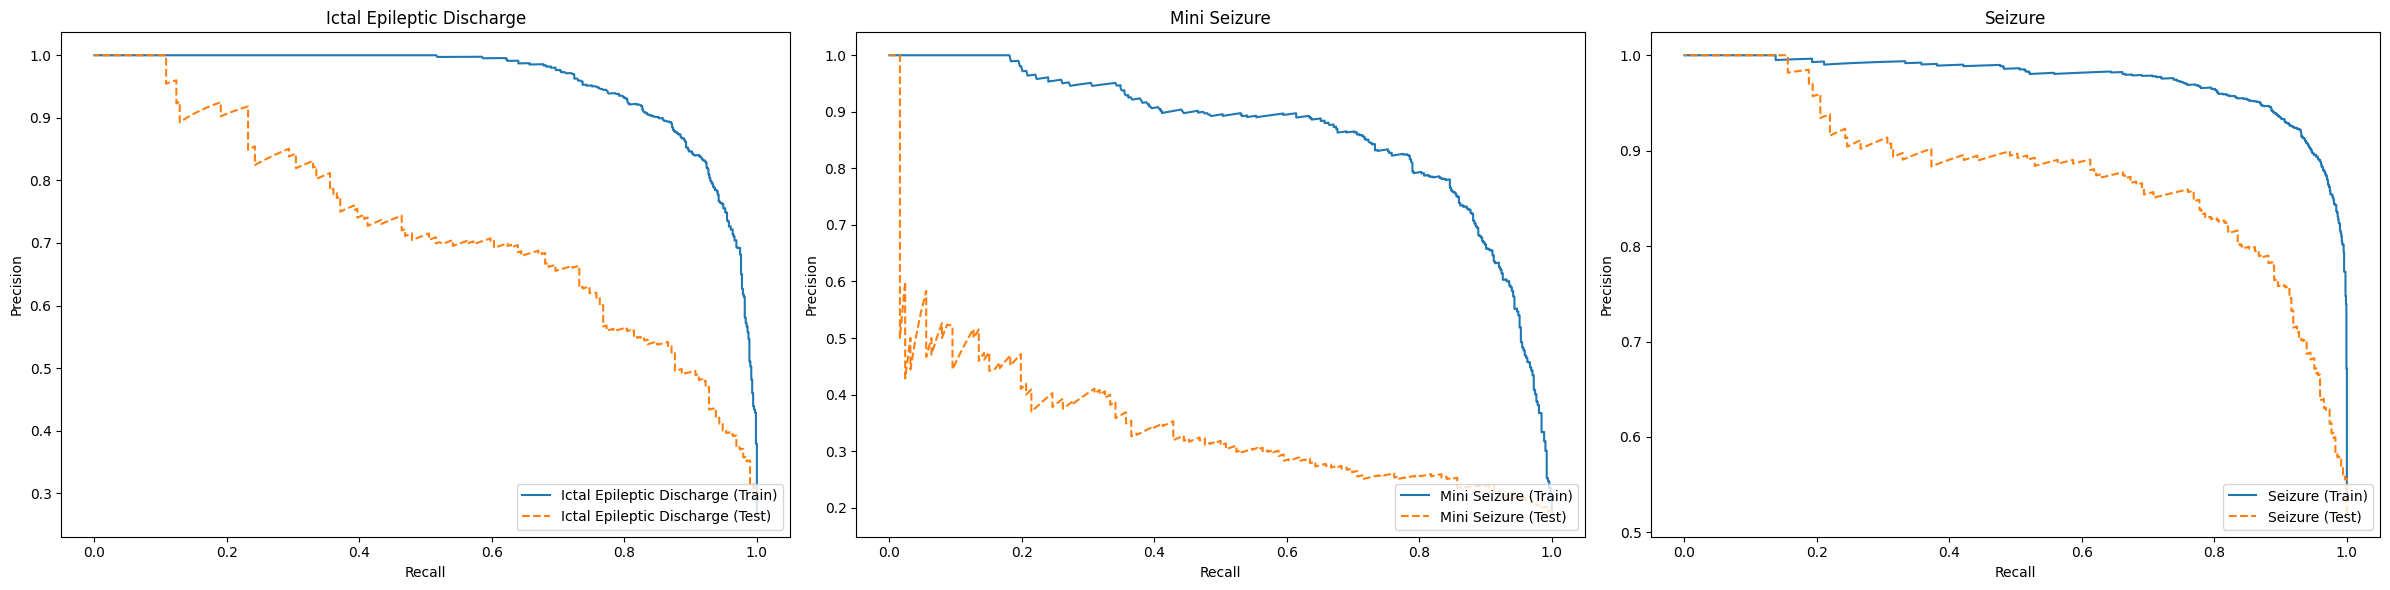

In [148]:
# Initialising lists to save curve precision-recall values
precision_train = {}
recall_train = {}
precision_test = {}
recall_test = {}

# Defining class names
class_names = ['Ictal Epileptic Discharge', 'Mini Seizure', 'Seizure']

# Calculation precision-recall curves for each class
for i in range(n_classes):
    precision_train[i], recall_train[i], _ = precision_recall_curve(y_train_encoded[:, i], y_train_prob[:, i])
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_test_encoded[:, i], y_test_prob[:, i])

fig, axes = plt.subplots(1, n_classes, figsize=(8 * n_classes, 6))

for i in range(n_classes):
    axes[i].plot(recall_train[i], precision_train[i], label=f'{class_names[i]} (Train)')
    axes[i].plot(recall_test[i], precision_test[i], label=f'{class_names[i]} (Test)', linestyle='--')

    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'{class_names[i]}')
    axes[i].legend(loc='lower right')
plt.tight_layout()
plt.savefig('Precision-Recall Curve(model_events).png')
plt.show()


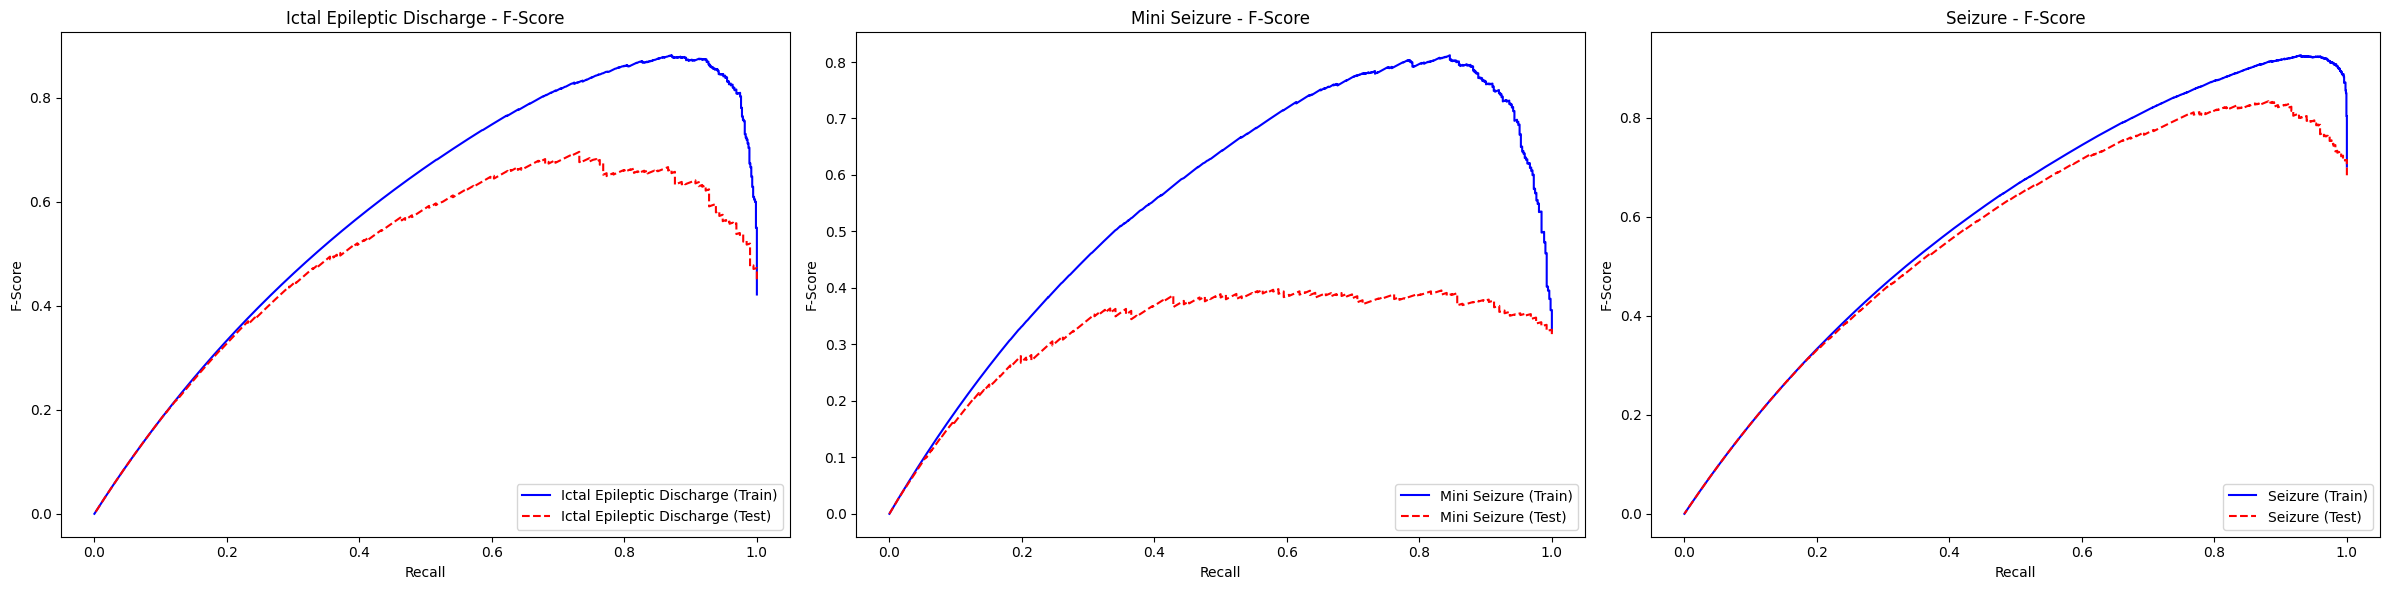

In [149]:
n_classes = y_train_encoded.shape[1]

# Initialize dictionaries to store F1 score curves
fscore_train = {}
fscore_test = {}

# Defining class names
class_names = ['Ictal Epileptic Discharge', 'Mini Seizure', 'Seizure']

# Calculate F1 score curves for each class
for i in range(n_classes):
    fscore_train[i] = 2 * (precision_train[i] * recall_train[i]) / (precision_train[i] + recall_train[i])
    fscore_test[i] = 2 * (precision_test[i] * recall_test[i]) / (precision_test[i] + recall_test[i])


fig, axes = plt.subplots(1, n_classes, figsize=(8 * n_classes, 6))

for i in range(n_classes):
    axes[i].plot(recall_train[i], fscore_train[i], label=f'{class_names[i]} (Train)', color='blue')
    axes[i].plot(recall_test[i], fscore_test[i], label=f'{class_names[i]} (Test)', linestyle='--', color='red')

    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('F-Score')
    axes[i].set_title(f'{class_names[i]} - F-Score')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.savefig('F-Score Curve(model_events).png')
plt.show()

**Defining features' impotance**

In [150]:
importances = model.named_steps['classifier'].feature_importances_

In [151]:
# Getting all columns after transformation
categorical_columns_transformed = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(np.concatenate([numerical_features, categorical_columns_transformed]))
all_feature_names

['F1_th/al',
 'F1_th/beta',
 'F1_th/gama',
 'F2_th/al',
 'F2_th/beta',
 'F2_th/gama',
 'T1_th/al',
 'T1_th/beta',
 'T1_th/gama',
 'T2_th/al',
 'T2_th/beta',
 'T2_th/gama',
 'P1_th/al',
 'P1_th/beta',
 'P1_th/gama',
 'P2_th/al',
 'P2_th/beta',
 'P2_th/gama',
 'O1_th/al',
 'O1_th/beta',
 'O1_th/gama',
 'O2_th/al',
 'O2_th/beta',
 'O2_th/gama',
 'Day_time_h_12-16',
 'Day_time_h_4-8',
 'SFN_treat_No_SFN',
 'SFN_treat_SFN']

In [152]:
# Getting features after transformation
categorical_columns_transformed = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(np.concatenate([numerical_features, categorical_columns_transformed]))

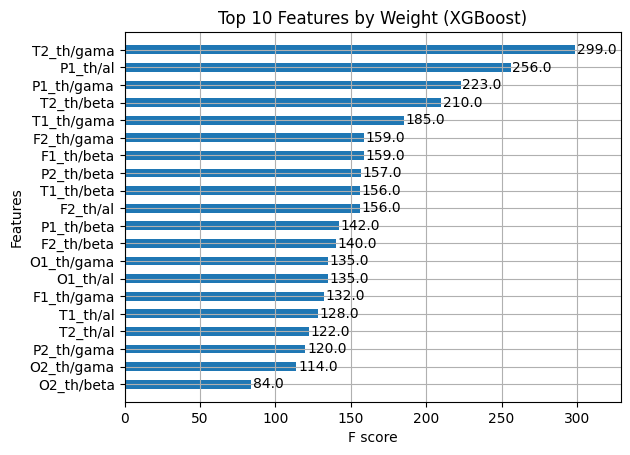

In [153]:
# Extract the XGBoost model
classifier = model.named_steps['classifier']

# Set feature names for PCA components in XGBoost
classifier.get_booster().feature_names = all_feature_names

# Plot feature importance
xgb.plot_importance(
    classifier,
    importance_type='weight',
    max_num_features=20,      # Top 20 features
    height=0.5
)

plt.title("Top 10 Features by Weight (XGBoost)")
plt.savefig('Top 10 Features by Weight (XGBoost).png')
plt.show()